In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
from sklearn.utils import resample

In [15]:
# Some defitions
IPAQ = 'IPAQ activity group | Instance 0'
PRS = 'Standard PRS for breast cancer (BC)'
PRS_QUARTILE = 'prs_quartile'
NUMBER_CANCERS = 'number_cancer'
HAS_BC = 'Breast'
ACCELEROMETER = 'Moderate-Vigorous - Overall average | Instance 0'
AC_QUARTILE = 'ac_quartile'
ASSESSMENT_DATE = 'Date of attending assessment centre | Instance 0'

In [16]:
demographics = pd.read_csv('cleaned_participant_table.csv')
diagnosis = pd.read_csv('cleaned_diagnosis_data.csv')

print(len(diagnosis))
print(len(demographics))

df = demographics.merge(diagnosis, right_on='eid', left_on='Participant ID', how='left').reset_index()
df.info(show_counts=True)

20093
51848
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51848 entries, 0 to 51847
Data columns (total 39 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   index                                                        51848 non-null  int64  
 1   Unnamed: 0_x                                                 51848 non-null  int64  
 2   Participant ID                                               51848 non-null  int64  
 3   Sleep - Overall average | Instance 0                         35091 non-null  float64
 4   Sedentary - Overall average | Instance 0                     35091 non-null  float64
 5   Light - Overall average | Instance 0                         35091 non-null  float64
 6   Moderate-Vigorous - Overall average | Instance 0             35091 non-null  float64
 7   IPAQ activity group | Instance 0                             461

In [25]:
# Substitute null values for breast cancer and number_cancers (aka for controls)
# df[HAS_BC] = df[HAS_BC].fillna(None)
df[NUMBER_CANCERS] = df[NUMBER_CANCERS].fillna(0)
df['cancer_before_assessment'] = df[HAS_BC] < df[ASSESSMENT_DATE]
df.groupby('cancer_before_assessment').count()

,index,Unnamed: 0_x,Participant ID,Sleep - Overall average | Instance 0,Sedentary - Overall average | Instance 0,Light - Overall average | Instance 0,Moderate-Vigorous - Overall average | Instance 0,IPAQ activity group | Instance 0,IPAQ activity group | Instance 1,IPAQ activity group | Instance 2,...,Breast,Cervix Uteri,Corpus Uteri,Other and Unspecified Female Genital Organs,Ovary,Uterus,Vagina,Vulva,number_cancer,cancer_after_assessment
cancer_before_assessment,,,,,,,,,,,,,,,,,,,,,
False,44987,44987,44987,33803,33803,33803,33803,41167,2619,8699,...,11487,29,260,174,1755,28,7,20,44987,44987
True,6861,6861,6861,1288,1288,1288,1288,5020,182,525,...,6861,10,117,14,56,14,1,11,6861,6861


In [46]:
## PICK THE SPORT MEASUREMENT ##

SPORT = IPAQ
#SPORT = ACCELEROMETER

# Separate cancer and non-cancer cases
clean_df = df[
    (df[SPORT].notnull()) & 
    (df[PRS].notnull()) & 
    (df[NUMBER_CANCERS] <= 1) & 
    (df['cancer_before_assessment'] == False)
]

cancer_group = clean_df[clean_df[NUMBER_CANCERS] == 1]
control_group = clean_df[clean_df[NUMBER_CANCERS] == 0]

# Undersample the control group to match the size of the cancer group
control_group_balanced = resample(control_group, 
                                  replace=False,  # No replacement, as we want to reduce size
                                  n_samples=len(cancer_group),  # Match size of cancer group
                                  random_state=42)  # For reproducibility

# Combine balanced data
sport_df = pd.concat([cancer_group, control_group_balanced])

# Add PRS Quartile
sport_df[PRS_QUARTILE]= pd.qcut(sport_df[PRS], q=4, labels=["Q1", "Q2", 'Q3', "Q4"])

# Add accelerometer quartiles
sport_df[ACCELEROMETER], bins= pd.qcut(sport_df[ACCELEROMETER], q=3, labels=["low", "moderate", "high"], retbins=True)
print(bins)

# Confirm the balance
print(sport_df[NUMBER_CANCERS].value_counts())

[0.      0.01244 0.02882 0.2619 ]
number_cancer
1.0    9026
0.0    9026
Name: count, dtype: int64


In [70]:
## Do people with a higher PRS develop cancer more frequently? ##

# Group by PRS quartile and IPAQ score
group_by = [PRS_QUARTILE, SPORT]
grouped = sport_df.groupby(group_by).agg(
    total_people=(NUMBER_CANCERS, 'count'),
    cancer_cases=(NUMBER_CANCERS, 'sum'),
    average_age=('age','mean')
).reset_index()

# Calculate the cancer rate (% of people who developed cancer)
grouped['cancer_rate'] = (grouped['cancer_cases'] / grouped['total_people']) * 100

# Normalize within each PRS quartile (to emphasize variation) - for each cancer_rate, what % is that of the total quartile rate
grouped['relative_risk_reduction'] = grouped.groupby(PRS_QUARTILE)['cancer_rate'].transform(
    lambda x: ((x.max()-x) / x.max()) * 100 # Relative risk reduction
)

# Display the results sorted by quartile and IPAQ score
grouped = grouped.sort_values(group_by)
display(grouped)

/tmp/ipykernel_2739/2838571028.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = sport_df.groupby(group_by).agg(
/tmp/ipykernel_2739/2838571028.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped['relative_risk_reduction'] = grouped.groupby(PRS_QUARTILE)['cancer_rate'].transform(


,prs_quartile,IPAQ activity group | Instance 0,total_people,cancer_cases,average_age,cancer_rate,relative_risk_reduction
0,Q1,0.0,786,297.0,72.020356,37.786260,0.000000
1,Q1,1.0,1929,635.0,72.421980,32.918611,12.882061
2,Q1,2.0,1798,589.0,72.621802,32.758621,13.305468
3,Q2,0.0,785,383.0,71.564331,48.789809,0.000000
4,Q2,1.0,2027,945.0,72.949186,46.620622,4.445984
5,Q2,2.0,1701,753.0,72.803057,44.268078,9.267778
6,Q3,0.0,828,465.0,72.090580,56.159420,0.000000
7,Q3,1.0,1970,1059.0,73.016751,53.756345,4.279024
8,Q3,2.0,1715,919.0,73.184257,53.586006,4.582338
9,Q4,0.0,788,564.0,72.903553,71.573604,0.000000


Chi-Square Statistic: 20.994137119333804
P-Value: 2.761728923876655e-05
Significant association between IPAQ score and cancer development.


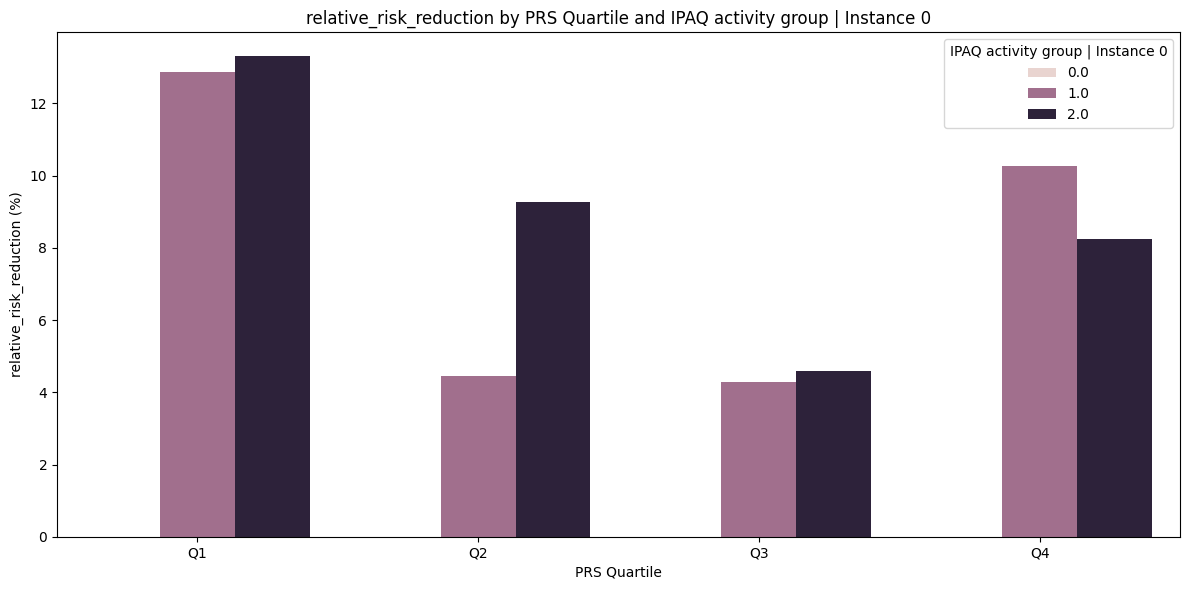

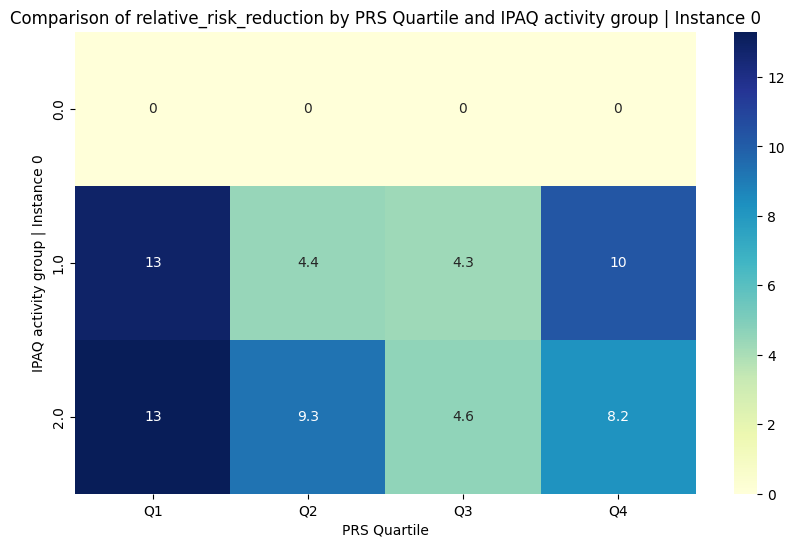

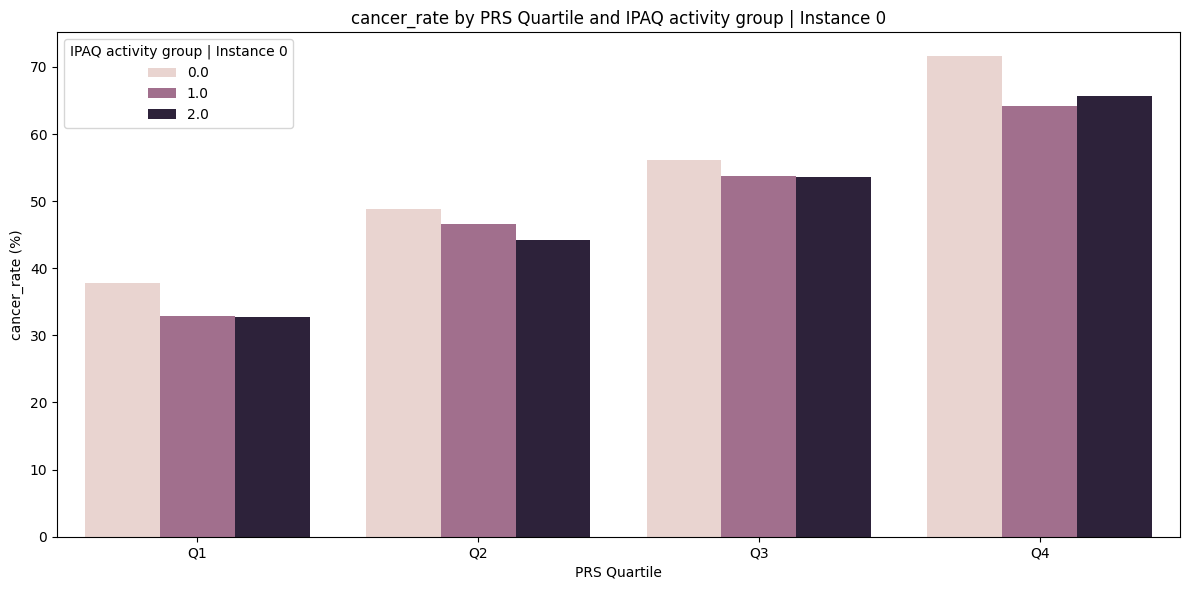

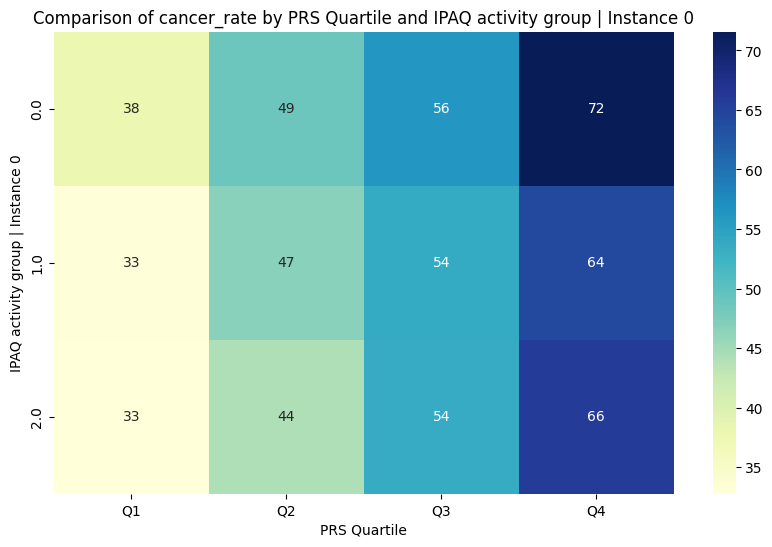

In [56]:
# Create a contingency table for statistical testing
contingency_table = pd.crosstab(sport_df[SPORT], sport_df[NUMBER_CANCERS])

# Perform the Chi-Square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant association between IPAQ score and cancer development.")
else:
    print("No significant association found.")

# Plotting cancer rate by PRS quartile and SPORT
values = ['relative_risk_reduction', 'cancer_rate']

for value in values: 
    # Bar Chart 
    plt.figure(figsize=(12, 6))
    sns.barplot(data=grouped, x=PRS_QUARTILE, y=value, hue=SPORT)
    plt.title('{0} by PRS Quartile and {1}'.format(value, SPORT))
    plt.ylabel('{0} (%)'.format(value))
    plt.xlabel('PRS Quartile')
    plt.legend(title=SPORT)
    plt.tight_layout()
    plt.show()

    # Heatmap
    pivot = grouped.pivot(index=SPORT, columns=PRS_QUARTILE, values=value)
    
    # Plot heatmap to compare cancer rates
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, cmap="YlGnBu")
    plt.title('Comparison of {0} by PRS Quartile and {1}'.format(value, SPORT))
    plt.ylabel(SPORT)
    plt.xlabel('PRS Quartile')
    plt.show()

T-statistic: 2.0996
P-value: 0.0359


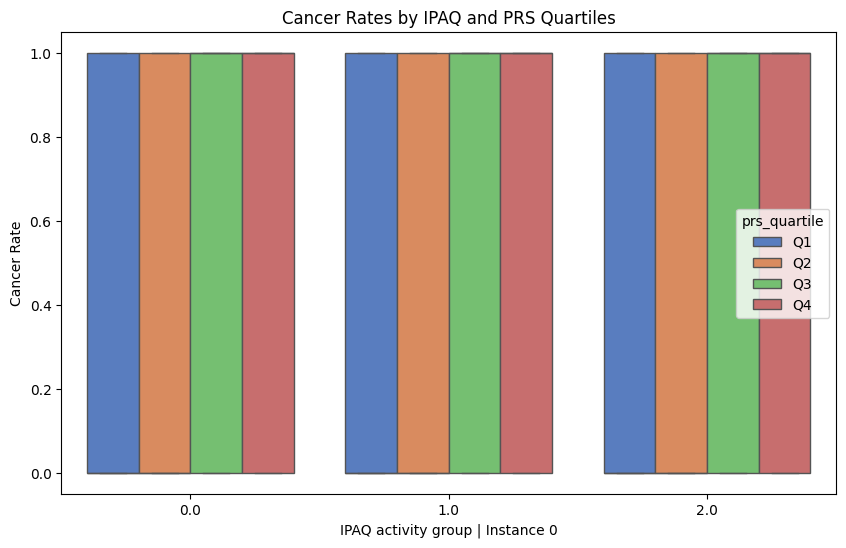

In [69]:
# Create PRS quartiles

# Compare cancer rates between high and low PRS within the 'high' activity group
high_ipaq_high_prs = sport_df[(sport_df[SPORT] == 0.0) & (sport_df[PRS_QUARTILE] == 'Q2')][NUMBER_CANCERS]
high_ipaq_low_prs = sport_df[(sport_df[SPORT] == 2.0) & (sport_df[PRS_QUARTILE] == 'Q2')][NUMBER_CANCERS]

# Perform the t-test
t_stat, p_value = stats.ttest_ind(high_ipaq_high_prs, high_ipaq_low_prs, equal_var=False)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x=SPORT, y=NUMBER_CANCERS, hue=PRS_QUARTILE, data=sport_df, palette="muted")
plt.title("Cancer Rates by IPAQ and PRS Quartiles")
plt.ylabel("Cancer Rate")
plt.show()

In [53]:
def chi_square_test(df):
    results = []
    for prs in ['Q1' ,'Q2', 'Q3', 'Q4']:
        subset = df[df[PRS_QUARTILE] == prs]
        
        # Create contingency table: IPAQ vs Cancer Cases
        contingency_table = pd.crosstab(subset[SPORT], subset[NUMBER_CANCERS])
        
        # Perform Chi-Square test
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        results.append({'PRS Quartile': prs, 'Chi-Square Stat': chi2, 'p-value': p_value})
        
        print(f"\nPRS Quartile {prs}")
        print(contingency_table)
        print(f"Chi-Square Stat: {chi2:.4f}, p-value: {p_value:.4f}")

        # Interpretation
        if p_value < 0.05:
            print("→ Significant variation by IPAQ score!")
        else:
            print("→ No significant variation by IPAQ score.")
    
    # Convert results to DataFrame for easy viewing
    return pd.DataFrame(results)

# Run the test
chi_square_results = chi_square_test(sport_df)


PRS Quartile Q1
number_cancer                                     0.0  1.0
Moderate-Vigorous - Overall average | Instance 0          
Q1                                                277  172
Q2                                                282  164
Q3                                                332  151
Q4                                                333  140
Chi-Square Stat: 10.9418, p-value: 0.0120
→ Significant variation by IPAQ score!

PRS Quartile Q2
number_cancer                                     0.0  1.0
Moderate-Vigorous - Overall average | Instance 0          
Q1                                                221  235
Q2                                                253  204
Q3                                                264  203
Q4                                                286  184
Chi-Square Stat: 14.7655, p-value: 0.0020
→ Significant variation by IPAQ score!

PRS Quartile Q3
number_cancer                                     0.0  1.0
Moderate-Vigorous - 

In [81]:
sport_df[PRS_QUARTILE] = pd.Categorical(sport_df[PRS_QUARTILE])

# Encode categorical variables as numeric (required for statsmodels)
sport_df['sports_score_code'] = sport_df[SPORT].cat.codes
sport_df['prs_quartile_code'] = sport_df[PRS_QUARTILE].cat.codes

def logistic_regression(df):
    results = []
    for prs in ['Q1' ,'Q2', 'Q3', 'Q4']:
        subset = df[df[PRS_QUARTILE] == prs]
        
        # Define outcome (Y) and predictor (X)
        X = subset[['sports_score_code']]  # Predictor (IPAQ quartile)
        y = subset[NUMBER_CANCERS]  # Outcome
        
        # Add a constant for the intercept
        X = sm.add_constant(X)
        
        # Fit logistic regression model
        model = sm.Logit(y, X).fit(disp=0)  # Suppress output during fitting
        summary = model.summary2()
        display(summary)
        
        # Calculate odds ratio and confidence intervals
        odds_ratios = pd.DataFrame(np.exp(model.params), columns=['Odds Ratio'])
        conf = np.exp(model.conf_int())
        conf.columns = ['2.5%', '97.5%']
        odds_ratios = pd.concat([odds_ratios, conf], axis=1)

        # Store results
        results.append({
            'PRS Quartile': prs,
            'Odds Ratio for IPAQ': odds_ratios.loc['sports_score_code', 'Odds Ratio'],
            '95% CI Lower': odds_ratios.loc['sports_score_code', '2.5%'],
            '95% CI Upper': odds_ratios.loc['sports_score_code', '97.5%'],
            'p-value': model.pvalues['sports_score_code']
        })
        
        print(f"\nPRS Quartile {prs} Logistic Regression Results:")
        print(odds_ratios)
        print(f"p-value: {model.pvalues['sports_score_code']:.4f}")

    return pd.DataFrame(results)

# Run logistic regression and store results
logistic_results = logistic_regression(sport_df)
logistic_results

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:               Logit            Method:           MLE      
Dependent Variable:  number_cancer    Pseudo R-squared: 0.004    
Date:                2025-01-07 20:59 AIC:              2363.6754
No. Observations:    1851             BIC:              2374.7224
Df Model:            1                Log-Likelihood:   -1179.8  
Df Residuals:        1849             LL-Null:          -1185.0  
Converged:           1.0000           LLR p-value:      0.0013156
No. Iterations:      5.0000           Scale:            1.0000   
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const             -0.4563   0.0816 -5.5900 0.0000 -0.6163 -0.2963
sports_score_code -0.1417   0.0442 -3.2050 0.0014 -0.2283 -0.0550
=================================================================

"""


PRS Quartile Q1 Logistic Regression Results:
                   Odds Ratio      2.5%     97.5%
const                0.633627  0.539948  0.743559
sports_score_code    0.867920  0.795900  0.946457
p-value: 0.0014


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: number_cancer    Pseudo R-squared: 0.005     
Date:               2025-01-07 20:59 AIC:              2533.6571 
No. Observations:   1850             BIC:              2544.7029 
Df Model:           1                Log-Likelihood:   -1264.8   
Df Residuals:       1848             LL-Null:          -1271.7   
Converged:          1.0000           LLR p-value:      0.00020821
No. Iterations:     4.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.0190   0.0784  0.2426 0.8083 -0.1347  0.1727
sports_score_code -0.1556   0.0421 -3.6975 0.0002 -0.2380 -0.0731
=================================================================

"""


PRS Quartile Q2 Logistic Regression Results:
                   Odds Ratio      2.5%    97.5%
const                1.019210  0.873990  1.18856
sports_score_code    0.855942  0.788197  0.92951
p-value: 0.0002


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: number_cancer    Pseudo R-squared: 0.004     
Date:               2025-01-07 20:59 AIC:              2542.0188 
No. Observations:   1850             BIC:              2553.0647 
Df Model:           1                Log-Likelihood:   -1269.0   
Df Residuals:       1848             LL-Null:          -1274.7   
Converged:          1.0000           LLR p-value:      0.00075509
No. Iterations:     4.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.3937   0.0787  5.0001 0.0000  0.2394  0.5480
sports_score_code -0.1418   0.0422 -3.3603 0.0008 -0.2246 -0.0591
=================================================================

"""


PRS Quartile Q3 Logistic Regression Results:
                   Odds Ratio      2.5%     97.5%
const                1.482473  1.270465  1.729859
sports_score_code    0.867755  0.798851  0.942601
p-value: 0.0008


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:               Logit            Method:           MLE      
Dependent Variable:  number_cancer    Pseudo R-squared: 0.002    
Date:                2025-01-07 20:59 AIC:              2349.3349
No. Observations:    1851             BIC:              2360.3819
Df Model:            1                Log-Likelihood:   -1172.7  
Df Residuals:        1849             LL-Null:          -1174.7  
Converged:           1.0000           LLR p-value:      0.044218 
No. Iterations:      5.0000           Scale:            1.0000   
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.8362   0.0824 10.1458 0.0000  0.6747  0.9977
sports_score_code -0.0880   0.0438 -2.0103 0.0444 -0.1739 -0.0022
=================================================================

"""


PRS Quartile Q4 Logistic Regression Results:
                   Odds Ratio      2.5%     97.5%
const                2.307551  1.963350  2.712096
sports_score_code    0.915722  0.840397  0.997798
p-value: 0.0444


,PRS Quartile,Odds Ratio for IPAQ,95% CI Lower,95% CI Upper,p-value
0,Q1,0.867920,0.795900,0.946457,0.001350
1,Q2,0.855942,0.788197,0.929510,0.000218
2,Q3,0.867755,0.798851,0.942601,0.000779
3,Q4,0.915722,0.840397,0.997798,0.044400
